In [1]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#change current working directory
%cd /content/drive/Shareddrives/Aplicacion inteligencia de la web/Lab2

/content/drive/Shareddrives/Aplicacion inteligencia de la web/Lab2


In [3]:
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 61 kB 556 kB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 895 kB 38.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=85067ec692c34e76c50d0079fb70889b21585346867006ed8cbd6d405294e8d8
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from seqeval.metrics import classification_report

import nltk
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import json

from nltk import word_tokenize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
BERT_MODEL_NAME = 'bert-base-uncased'
DATASET_FILEPATH = './events/aviation.txt'


TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 35
LEARNING_RATE = 1e-05

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## 1. Transform the CONCISUS event files to BIO format ##

### Transform XML to BIO dict format ###

In [8]:
# obtain all xml files to process
def get_all_xml_files(basepath):
    basepath = Path(basepath)
    return sorted(list(basepath.glob('avion-*.xml')))

# process one file returning a list of sentences
#Procesamos el texto y lo convertimos a diccionario
def xml_to_dict(filepath):
    # extract each xml element into dictionary
    tree = ET.parse(filepath)
    root = tree.getroot()
    sentences = []
    count_h = 0
    sec_num = 0
    #boleano para indicar si hemos encontrado la seccion H1
    #De esta manera evitamos errores en la lectura del texto
    for id, element in enumerate(root.iter()):
      if element.text is not None:
        words = element.text.split()
        for i in range(len(words)):
          if i == 0:
            sentences.append(tuple([words[i], "B-"+element.tag]))
          else:
            sentences.append(tuple([words[i], "I-"+element.tag]))
      
      if element.tail is not None:
        words = element.tail.split()
        for i in range(len(words)):
            sentences.append(tuple([words[i], "O"]))
      

    return sentences
  

In [9]:
# Get all XML convert to Dict
filepaths = get_all_xml_files('./concisus')
sentences = [xml_to_dict(file) for file in filepaths]


### Save Dict to txt file ###

In [10]:
# Save all xml into a txt file in BIO format.
file2write=open(DATASET_FILEPATH,'w')
for sentence in sentences:
  for element in sentence:
    file2write.write("{}\t{}\n".format(element[0], element[1]))
  file2write.write("\n")
file2write.close()

### Read Sentences from txt file ###

In [11]:
def yield_lines(filepath):
    with Path(filepath).open('r') as f:
        for line in f:
            yield line.strip('\n')
            

def read_file(filepath):
    docs = []
    doc = []
    for line in yield_lines(filepath):
        if len(line) == 0 and len(doc) > 0: # reaches empty line
          docs.append(doc)
          doc = []
        else:
          # for tag in ['B-Perpetrator', 'I-Perpetrator', 'I-Fatalities', 'I-Place', 'B-Injured']: # remove tags
          #     line = line.replace(tag, 'O')
          doc.append(tuple(line.split('\t')))

    return docs

# Read sentences from txt file.     
sentences = read_file(DATASET_FILEPATH)
sentences[0]

[('2009', 'B-Year'),
 ('June', 'B-DateOfAccident'),
 ('1', 'I-DateOfAccident'),
 ('?', 'O'),
 ('Air', 'B-Airline'),
 ('France', 'I-Airline'),
 ('Flight', 'B-FlightNumber'),
 ('447', 'I-FlightNumber'),
 (',', 'O'),
 ('an', 'O'),
 ('Airbus', 'B-TypeOfAircraft'),
 ('A330-200', 'I-TypeOfAircraft'),
 ('flying', 'O'),
 ('from', 'O'),
 ('Rio', 'B-Origin'),
 ('de', 'I-Origin'),
 ('Janeiro,', 'I-Origin'),
 ('Brazil', 'I-Origin'),
 ('to', 'O'),
 ('Paris,', 'B-Destination'),
 ('France', 'I-Destination'),
 (',', 'O'),
 ('crashes', 'B-TypeOfAccident'),
 ('in', 'O'),
 ('the', 'O'),
 ('Atlantic', 'B-Place'),
 ('Ocean', 'I-Place'),
 ('killing', 'O'),
 ('all', 'O'),
 ('228', 'B-NumberOfVictims'),
 ('occupants,', 'O'),
 ('including', 'O'),
 ('12', 'B-Tripulation'),
 ('crew;', 'O'),
 ('bodies', 'O'),
 ('and', 'O'),
 ('aircraft', 'O'),
 ('debris', 'O'),
 ('are', 'O'),
 ('not', 'O'),
 ('recovered', 'O'),
 ('until', 'O'),
 ('several', 'O'),
 ('days', 'O'),
 ('later.', 'O')]

## 2. Adaptation of system to our domain ##

In [12]:
# building X, y
X = [[word for word, _ in sentence] for sentence in sentences]
y = [[tag for _, tag in sentence] for sentence in sentences]

# splitting data from training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

print("X[0]:", X[0])
print("y[0]:", y[0])

print("Size X_train: ", len(X_train))
print("Size X_valid: ", len(X_valid))
print("Size X_test: ", len(X_test))

X[0]: ['2009', 'June', '1', '?', 'Air', 'France', 'Flight', '447', ',', 'an', 'Airbus', 'A330-200', 'flying', 'from', 'Rio', 'de', 'Janeiro,', 'Brazil', 'to', 'Paris,', 'France', ',', 'crashes', 'in', 'the', 'Atlantic', 'Ocean', 'killing', 'all', '228', 'occupants,', 'including', '12', 'crew;', 'bodies', 'and', 'aircraft', 'debris', 'are', 'not', 'recovered', 'until', 'several', 'days', 'later.']
y[0]: ['B-Year', 'B-DateOfAccident', 'I-DateOfAccident', 'O', 'B-Airline', 'I-Airline', 'B-FlightNumber', 'I-FlightNumber', 'O', 'O', 'B-TypeOfAircraft', 'I-TypeOfAircraft', 'O', 'O', 'B-Origin', 'I-Origin', 'I-Origin', 'I-Origin', 'O', 'B-Destination', 'I-Destination', 'O', 'B-TypeOfAccident', 'O', 'O', 'B-Place', 'I-Place', 'O', 'O', 'B-NumberOfVictims', 'O', 'O', 'B-Tripulation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Size X_train:  24
Size X_valid:  3
Size X_test:  4


### Data analysis ###

In [13]:
from collections import Counter
print("Number of documents:", len(sentences))
print("Frequency")
counter = sorted(Counter([tag for sentence in sentences for _, tag in sentence]).items(), key=lambda x: x[1], reverse=True)
for tag, val in counter:
    print(f'{tag:20} {val}')
    
print("\nEach tag appears in number of documents")
docs = {}
for i, sentence in enumerate(sentences):
    for _, tag in sentence:
        if tag not in docs:
            docs[(i, tag)] = 1
        else:
            docs[(i, tag)] += 1
counter = Counter([tag for i, tag in docs])
for tag in counter:
  print(f'{tag:20} {counter[tag]}') 

Number of documents: 31
Frequency
O                    729
I-Place              78
I-Cause              45
I-TypeOfAircraft     34
B-TypeOfAircraft     31
B-Year               30
B-Airline            30
B-FlightNumber       30
I-FlightNumber       30
B-DateOfAccident     29
I-Airline            29
I-DateOfAccident     27
B-TypeOfAccident     27
B-Place              27
B-NumberOfVictims    22
I-Origin             15
I-Destination        13
B-Cause              13
I-TypeOfAccident     10
B-Survivors          10
B-Passenger          9
B-Destination        7
B-Tripulation        6
B-Origin             5
I-Passenger          1

Each tag appears in number of documents
B-Year               30
B-DateOfAccident     29
I-DateOfAccident     27
O                    31
B-Airline            28
I-Airline            23
B-FlightNumber       28
I-FlightNumber       28
B-TypeOfAircraft     28
I-TypeOfAircraft     27
B-Origin             5
I-Origin             5
B-Destination        7
I-Destination       

### Data analisis and Initialize Bert tokenizer ###

In [14]:
all_words = set([word for sentence in sentences for word, _ in sentence])

max_seq_len = max([len(x) for x in X])
max_seq_len = 128 if max_seq_len<128 else max_seq_len
print("max_seq_leng:", max_seq_len)

n_words = len(all_words)
print("Number of words:", n_words)
print("Words: ", all_words)

all_tags = set([tag for sentence in sentences for _, tag in sentence])
num_tags = len(all_tags)
print("Number of tags:", num_tags)
print("Tags:", all_tags)

tag2index = {tag: i for i, tag in enumerate(all_tags)}
index2tag = {i: tag for tag, i in tag2index.items()}

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)


max_seq_leng: 128
Number of words: 533
Words:  {'June', 'that', '1907', 'PMTair', '626', '21', 'final', '2009', 'western', 'responsibility', 'A330-200', 'Smolensk', '251', '130', 'Out', '737-800,', 'injuries.', '737-800.', 'Azores', 'France', 'TAM', '236', 'Russia', 'near', 'survivors.', 'Moroni,', 'M?rida,', 'York', 'members', '83', 'of', 'down', '29', 'several', '152', '2008', 'high', '1996', 'out', 'tail', 'runs', '312', 'loss', 'first', '8969', '85', '2006', 'Queens', 'just', 'All', 'Air', 'Q400', '16', 'May', 'fatal', 'officials', 'apparently', '12', 'Caribbean', 'people', 'attempting', 'Santiago', 'injured.', 'multiple', 'Venezuela', 'splits', 'Bangkok', 'GIA.', 'waters', 'runway', 'Airways', 'A320', 'Irkutsk', 'Janeiro,', 'Algiers,', 'ever', 'passengers', 'International', '96/96', '145', '1990', 'London', 'land', 'injuries,', 'Vincennes', 'disaster.', 'John', 'in', 'for', '9', 'hijacked', 'Margalla', '52', 'explodes', 'MD-82', 'Bishkek,', 'Liberty', 'this', 'business', 'fly', 't

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Preparing the dataset and dataloader ###


In [15]:
class dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
        self.len = len(X)
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.X[index]
        word_labels = self.y[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2index[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [16]:
training_set = dataset(X_train, y_train, tokenizer, max_seq_len)
validation_set = dataset(X_valid, y_valid, tokenizer, max_seq_len)
testing_set = dataset(X_test, y_test, tokenizer, max_seq_len)

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

### BERT Model. ###


In [17]:
model = BertForTokenClassification.from_pretrained(BERT_MODEL_NAME, num_labels=len(tag2index))
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Training the model: ###


In [18]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [19]:
def valid(model, data_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # if idx % 100==0:
            #     loss_step = eval_loss/nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # print(f"Validation : loss {eval_loss:.2f} accuracy {eval_accuracy:.2f}")

    return labels, predictions, eval_loss, eval_accuracy

In [20]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    with tqdm(training_loader, 'batch') as tepoch:
        for idx, batch in enumerate(tepoch):
            tepoch.set_description(f'Epoch {epoch}')
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss, tr_logits = outputs[0], outputs[1]
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)
            
            # if idx % 100==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     print(f"Training loss per 100 training steps: {loss_step:.2f}")
            
            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
            
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            tr_labels.extend(labels)
            tr_preds.extend(predictions)

            tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            tr_accuracy += tmp_tr_accuracy
        
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=10
            )
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=tr_loss / nb_tr_steps, accuracy=tr_accuracy / nb_tr_steps)
    
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
              
    _, _ , val_loss, val_acc = valid(model, validation_loader)
    
    return epoch_loss, tr_accuracy, val_loss, val_acc

In [21]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[], 'epoch':[]}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['epoch'].append(epoch+1)

Epoch 34: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s, accuracy=0.976, loss=0.187]


## 3. Performance report on test data ##

<function matplotlib.pyplot.show>

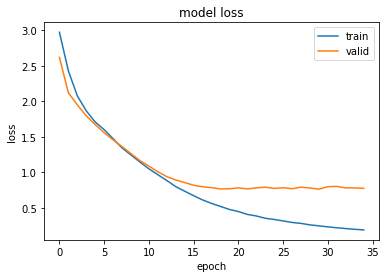

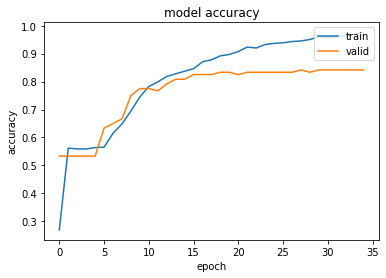

In [22]:
plt.figure(1)
plt.plot(history[f'train_loss'])
plt.plot(history[f'val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

plt.figure(2)
plt.plot(history[f'train_accuracy'])
plt.plot(history[f'val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

In [23]:
labels, predictions, loss, accuracy = valid(model, testing_loader)
print(f"Validation : loss {loss:.2f} accuracy {accuracy:.2f}")

from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

# for source, pred in zip(labels, predictions):
#   print(f'{source:20} {pred}')



Validation : loss 0.87 accuracy 0.84
                 precision    recall  f1-score   support

        Airline       0.75      0.75      0.75         4
          Cause       0.33      1.00      0.50         1
 DateOfAccident       0.75      0.75      0.75         4
   FlightNumber       0.80      1.00      0.89         4
NumberOfVictims       0.50      0.67      0.57         3
      Passenger       0.50      0.50      0.50         2
          Place       0.50      1.00      0.67         3
      Survivors       0.00      0.00      0.00         1
    Tripulation       1.00      1.00      1.00         1
 TypeOfAccident       0.67      0.67      0.67         3
 TypeOfAircraft       0.67      1.00      0.80         4
           Year       0.75      1.00      0.86         3

      micro avg       0.63      0.82      0.71        33
      macro avg       0.60      0.78      0.66        33
   weighted avg       0.65      0.82      0.71        33



## 4. Showing the full extracted strings ##

In [24]:
for source, pred in zip(labels, predictions):
  print(f'{source:20} {pred}')

B-Year               B-Year
B-DateOfAccident     B-DateOfAccident
I-DateOfAccident     I-DateOfAccident
O                    O
B-Airline            B-Airline
B-FlightNumber       B-FlightNumber
I-FlightNumber       I-FlightNumber
O                    O
O                    O
B-TypeOfAircraft     B-TypeOfAircraft
I-TypeOfAircraft     I-TypeOfAircraft
O                    O
B-TypeOfAccident     B-TypeOfAccident
O                    O
O                    O
O                    I-Place
O                    O
O                    I-Place
B-Place              B-Place
I-Place              I-Place
I-Place              I-Place
I-Place              I-Place
I-Place              I-Place
O                    O
O                    O
O                    O
B-Passenger          O
I-Passenger          I-Cause
O                    O
O                    O
B-NumberOfVictims    B-Passenger
O                    O
O                    O
B-Tripulation        B-Tripulation
O                    O
O          

## 5. Save model ##

In [25]:
path = './model/aviation-accidents.pt'
#saving model: 
torch.save(model, path)
print('Torch model saved')


directory = Path("./model")
directory.mkdir(parents=True, exist_ok=True)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(str(directory))
# save the model weights and its configuration file
model.save_pretrained(directory)

# Cosa para guardar
data2save = {}
data2save["max_seq_len"] = max_seq_len
data2save["index2tag"] = index2tag
with open('./model/data.json', 'w') as f:
  json.dump(data2save, f)

#save tags
print('All files saved')

Torch model saved
All files saved
